# Transpose Demo

Transpose offers deep flexibility for accessing and running analysis on Ethereum data. Bottom-up indexing means complete coverage of EVM primitives (all token types, accounts, settlement data) with higher-order datatypes 

This demo will demonstrate how our Python SDK can be used to carry out powerful analyses across blockchain data.


### Blockchain Data Stack
* Data is actually stored as 'settlement data'
    * This is the data we all know and love from block explorers and node providers
    * It explains everything but is a pain to work with
* Asset data is one layer of abstraction up from settlement data. This includes fungible and non-fungible tokens
* Protocol Data (NFT Exchanges, DEXes & Defi, Game Contracts)
    * The actually useful stuff! Hard to get to today


## Summary of topics covered
- Accounts, NFTs and Tokens
- NFT Sales
- Token Swaps (DEX activity)
- NFT Collection Holder Similarity Analysis
- Sales analysis
- Mint analysis

In [212]:
from IPython.display import display
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool
from dateutil import parser
from transpose.src.util.models import NFTTransfer, TokenTransfer
from datetime import timedelta, datetime
from transpose import Transpose
from pprint import pprint
import json
import os

API_KEY = os.environ['TRANSPOSE_KEY']
api = Transpose(API_KEY)

# Basics - accounts, NFTs, tokens

In [214]:
calvey_wallet = 'telemachus.eth'
nfts = api.nft.nfts_by_owner(calvey_wallet, limit=100)
nfts.to_dict()

[{'contract_address': '0x1347A97789cd3Aa0b11433E8117F55Ab640A0451',
  'token_id': 3538,
  'name': 'Long Lost #3538',
  'description': "Long Lost is a 10,000 piece genesis collection from the '5th Dimension Collective'.",
  'minted_timestamp': '2022-02-06T00:11:49Z',
  'supply': 1,
  'image_url': 'https://ipfs.io/ipfs/QmZWZ4LhQJesCo7jXwNax9PKfd4Si27o5zrSgQVexdoqnn/3538.png',
  'media_url': None,
  'external_url': None,
  'properties': [{'trait_type': 'Backgrounds', 'value': 'Blue BG'},
   {'trait_type': 'Skeleton', 'value': 'Silver Skele'},
   {'trait_type': 'Clothes', 'value': 'Pistachio Hoodie'},
   {'trait_type': 'Eyes', 'value': 'XO'},
   {'trait_type': 'Headwear', 'value': 'Cool Cat Hat'}],
  'metadata_url': 'https://ipfs.io/ipfs/QmYhq21Z1T4B8dxFKXgtZirxMQhNaHomMFdPRDmus2sspK/3538.json',
  'last_refreshed': '2022-05-18T04:38:51Z',
  'owner': '0x3f4C85754A36Cb81067a0A88Bb1f83B9Cef97a91',
  'balance': 1},
 {'contract_address': '0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85',
  'token_id

In [215]:
# Let's look at one of these
api.nft.collections_by_contract_address(nfts[1].contract_address)[0].to_dict()

{'contract_address': '0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85',
 'name': 'ENS',
 'symbol': 'ENS',
 'description': 'Ethereum Name Service (ENS) domains are secure domain names for the decentralized world. ENS domains provide a way for users to map human readable names to blockchain and non-blockchain resources, like Ethereum addresses, IPFS hashes, or website URLs. ENS domains can be bought and sold on secondary markets.',
 'created_timestamp': '2020-01-30T00:47:51Z',
 'standard': 'ERC-721',
 'count': 1771384,
 'external_url': 'https://ens.domains',
 'image_url': None,
 'twitter_username': 'ensdomains',
 'telegram_url': None,
 'discord_url': None,
 'is_nsfw': False,
 'opensea_slug': 'ens',
 'opensea_url': 'https://opensea.io/collection/ens',
 'last_refreshed': '2022-07-20T19:09:31Z'}

In [216]:
# It's easy to search NFTs by name as well
BORED_APE_CONTRACT_ADDRESS = '0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D'

fake_baycs = api.nft.collections_by_symbol('bored', fuzzy='true', limit=30)

print('number of contracts matching "bored ape": {}'.format(len(fake_baycs)))
for fake_bayc in fake_baycs:
    is_real = bool(fake_bayc.contract_address == BORED_APE_CONTRACT_ADDRESS)
    print('Name: {}'.format(fake_bayc.name))
    print('Symbol: {}'.format(fake_bayc.symbol))
    print('Created: {}'.format(fake_bayc.created_timestamp))
    print('Is Real: {}\n'.format(is_real))

number of contracts matching "bored ape": 30
Name: bored in a bear market
Symbol: BORED
Created: 2022-06-04T17:03:36Z
Is Real: False

Name: Bored Bad Boys
Symbol: BoredBadBoys
Created: 2022-04-13T22:30:00Z
Is Real: False

Name: NobleBored
Symbol: NobleBored
Created: 2022-07-27T07:26:50Z
Is Real: False

Name: WifeBoredApe
Symbol: WifeBoredApe
Created: 2022-07-30T08:00:50Z
Is Real: False

Name: CoolBoredApe
Symbol: CoolBoredApe
Created: 2022-07-27T07:27:19Z
Is Real: False

Name: BAYC Land Sale
Symbol: BoredApeLAND
Created: 2022-03-17T13:58:16Z
Is Real: False

Name: Bored Lambs
Symbol: boredlambs
Created: 2022-01-20T08:32:36Z
Is Real: False

Name: BoredOne
Symbol: BORED
Created: 2022-06-11T18:50:11Z
Is Real: False

Name: BoredBunnyClub
Symbol: BoredBunnyClub
Created: 2022-08-05T11:01:32Z
Is Real: False

Name: NFT Bored Bad Bunny Official
Symbol: boredbad
Created: 2022-01-21T17:03:21Z
Is Real: False

Name: BoredMeka
Symbol: BOREDMEKA
Created: 2022-02-28T16:39:22Z
Is Real: False

Name: Bore

In [217]:
# let's pull the 5 most recently created collections
most_recent_collections = api.nft.collections_by_date_created(order='desc', limit=5)
for collection in most_recent_collections:
    print(collection.name)

Proof of Narnian NFT
My world
Club Alena Test
Question Marks
pepestory


In [218]:
# Tokens are just as easy to work with
tokens = api.token.tokens_by_owner(calvey_wallet)

tokens[0].to_dict()

{'contract_address': '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0',
 'name': 'Matic Token',
 'symbol': 'MATIC',
 'decimals': 18,
 'description': 'Matic Network brings massive scale to Ethereum using an adapted version of Plasma with PoS based side chains. Polygon is a well-structured, easy-to-use platform for Ethereum scaling and infrastructure development.',
 'created_timestamp': '2019-04-20T16:34:12Z',
 'standard': 'ERC-20',
 'supply': 10000000000000000000000000000,
 'external_url': 'https://polygon.technology/',
 'image_url': None,
 'twitter_username': '0xPolygon',
 'telegram_url': 'https://t.me/polygonofficial',
 'discord_url': 'https://discord.gg/polygon',
 'whitepaper_url': 'https://polygon.technology/papers',
 'last_refreshed': '2022-07-21T05:41:18Z',
 'owner': '0x3f4C85754A36Cb81067a0A88Bb1f83B9Cef97a91',
 'balance': 3304801670000000000}

# NFT Sales

In [227]:
# let's retrieve the last month of sales for bored apes
start_date = '2022-07-01'
recent_sales = api.bulk_request(api.nft.sales_by_contract_address(
    BORED_APE_CONTRACT_ADDRESS, limit=500, sold_after=start_date), 20, 100000)

print("Number of BAYC sales in last month: {}".format(len(recent_sales)))

Number of BAYC sales in last month: 388


In [228]:
# Let's check data again
recent_sales[0].to_dict()

{'contract_address': '0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D',
 'token_id': 7596,
 'block_number': 15053589,
 'log_index': 88,
 'transaction_hash': '0xc8e8e72c4f30789e6fe541adfbd974faa79698d39103e342b7b74ce62135fdee',
 'timestamp': '2022-07-01T01:19:11Z',
 'exchange_name': 'opensea',
 'contract_version': 'seaport',
 'is_multi_token_sale': False,
 'multi_token_sale_index': 0,
 'quantity': 1,
 'payment_token': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
 'price': 99000000000000000000,
 'eth_price': 99.0,
 'usd_price': 101898.77,
 'buyer': '0xb6674e0f123652fF18FA10ce2Eca886fC60E07E4',
 'seller': '0xB39734396B95660707EF7F3D3A76e8566Ee34377'}

In [229]:
usd_volume = 0
eth_volume = 0
daily_usd_volume = {}

for sale in recent_sales:
    usd_volume += sale.usd_price
    eth_volume += sale.eth_price
    date = parser.parse(sale.timestamp)
    day = date.strftime('%Y-%m-%d')
    if day not in daily_usd_volume:
        daily_usd_volume[day] = 0.0
    daily_usd_volume[day] += sale.usd_price

print('USD Volume: {}'.format(usd_volume))
print('ETH Volume: {}\n'.format(eth_volume))
print(json.dumps(daily_usd_volume, indent=4))

USD Volume: 52916032.20999996
ETH Volume: 38842.68790157986

{
    "2022-07-01": 1868896.3,
    "2022-07-02": 707493.5900000001,
    "2022-07-03": 692914.9600000001,
    "2022-07-04": 1007400.1699999999,
    "2022-07-05": 877555.1599999999,
    "2022-07-06": 1763882.6199999999,
    "2022-07-07": 2297094.8699999996,
    "2022-07-08": 1999564.4999999998,
    "2022-07-09": 1611806.98,
    "2022-07-10": 2799534.57,
    "2022-07-11": 545821.86,
    "2022-07-12": 1121307.04,
    "2022-07-13": 2169033.0100000002,
    "2022-07-14": 932500.2600000001,
    "2022-07-15": 1790289.9999999995,
    "2022-07-16": 1317101.44,
    "2022-07-17": 1099997.0599999998,
    "2022-07-18": 1532957.86,
    "2022-07-19": 1302360.14,
    "2022-07-20": 1035461.19,
    "2022-07-21": 2176903.1,
    "2022-07-22": 1603572.35,
    "2022-07-23": 573117.22,
    "2022-07-24": 844743.4199999999,
    "2022-07-25": 1551576.1600000001,
    "2022-07-26": 841020.8999999999,
    "2022-07-27": 864280.23,
    "2022-07-28": 1125067.

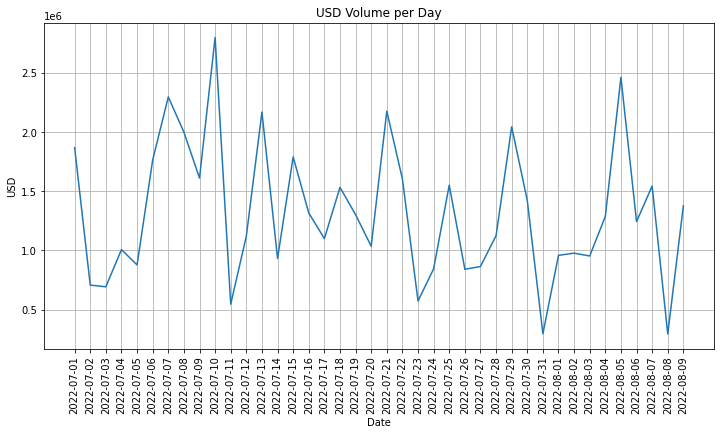

In [230]:
# let's plot the USD revenue per day
plt.figure(figsize=(12, 6))
plt.title('USD Volume per Day')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.xticks(rotation=90)
plt.plot(list(daily_usd_volume.keys()), list(daily_usd_volume.values()))
plt.show()

In [231]:
# Let's break down sales by exchange:

exchanges = {}
for sale in recent_sales:
    if sale.exchange_name in exchanges.keys():
        exchanges[sale.exchange_name] += int(sale.usd_price)
    else:
        exchanges[sale.exchange_name] = int(sale.usd_price)
    
exchanges = {k: v for k, v in sorted(exchanges.items(), key=lambda item: item[1], reverse=True)}
for exchange in exchanges:
    print(str(exchanges[exchange]) + " on " + exchange) 

29364612 on opensea
18559558 on x2y2
4839103 on looksrare
152584 on 0x


## Swap Data

In [232]:
# Let's pull the last 10000 token swap data across all DEXes
swaps = api.bulk_request(api.token.swaps(order='desc', limit=500), 20, 1000)
print("Found {} token swaps".format(len(swaps)))

Found 1000 token swaps


In [233]:
# Let's take a look at the data in a single swap
swaps[0].to_dict()

{'pair_contract_address': '0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640',
 'from_token': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
 'to_token': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
 'block_number': 15308997,
 'log_index': 327,
 'transaction_hash': '0x452324702e7b96450a11a927570f82bf2f409290438cfbea403b753038d979cf',
 'timestamp': '2022-08-09T16:16:45Z',
 'exchange_name': 'Uniswap',
 'contract_version': 'v3',
 'quantity_in': 5000000000000000000,
 'quantity_out': 8410049628,
 'effective_price': 1.6820099256e-09,
 'sender': '0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45',
 'origin': '0x1E109b6c42A44d839d6a0E66548cAfa6AdAd1435'}

In [234]:
# Let's quickly break these down by DEX

dexes = {}

for swap in swaps:
    if swap.exchange_name in dexes:
        dexes[swap.exchange_name] += 1
    else:
        dexes[swap.exchange_name] = 1
        
dexes

{'Uniswap': 914, 'Sushiswap': 80, 'Balancer': 5, '0x': 1}

In [235]:
# And how about most common pairs?
contracts = {}
for swap in swaps:
    if swap.from_token in contracts:
        contracts[swap.from_token] += 1
    else:
        contracts[swap.from_token] = 1
    if swap.to_token in contracts:
        contracts[swap.to_token] += 1
    else:
        contracts[swap.to_token] = 1
        
contracts = {k: v for k, v in sorted(contracts.items(), key=lambda item: item[1], reverse=True)}
contracts

{'0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2': 891,
 '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48': 198,
 '0x0E6E76fd414694B307f35E6C5eED6af5a3281e9D': 86,
 '0xdAC17F958D2ee523a2206206994597C13D831ec7': 80,
 '0x4fb18e79EcB13af415FAef0AeA1CB3a69Ae73923': 38,
 '0x7F50a031EaCA25eAD1e73D1EdA2a26F4586e4766': 38,
 '0x6B175474E89094C44Da98b954EedeAC495271d0F': 31,
 '0x7D371244675ef6a7B0A61d235624D67cb5B33304': 30,
 '0xc6276F4011cc9965A0f7Fb5d6E605C9D55058E65': 23,
 '0xb8110896d6F6055bB3DA35904b8Bf040064dEFD9': 19,
 '0x7822d4704B615a4F499f3F6db18fA02281e2b751': 19,
 '0x2b591e99afE9f32eAA6214f7B7629768c40Eeb39': 18,
 '0xC3f65b1c45B0D42a472CD0Fbd37dD6678AEf667a': 18,
 '0x516A2893Fb0300D88C99d1622744DC0233095402': 17,
 '0x67873a14804e9db31De66601E8f81FDEf0169BEe': 15,
 '0xe76C6c83af64e4C60245D8C7dE953DF673a7A33D': 15,
 '0x0B452278223D3954F4AC050949D7998e373e7E43': 13,
 '0xeF497B970f50286a9805b91809b8615E6d0eF19B': 13,
 '0xaaAEBE6Fe48E54f431b0C390CfaF0b017d09D42d': 12,
 '0x514910771AF9Ca656af840dff

In [239]:
from pprint import pprint
# Let's pull info on the top 5 coins
for i in range(5):
    pprint(api.token.tokens_by_contract_address(list(contracts.keys())[i]).to_dict())
    print("\n")

[{'contract_address': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
  'created_timestamp': '2017-12-18T08:40:53Z',
  'decimals': 18,
  'description': 'wETH is "wrapped ETH"',
  'discord_url': None,
  'external_url': 'https://weth.io/',
  'image_url': 'https://raw.githubusercontent.com/trustwallet/assets/master/blockchains/ethereum/assets/0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2/logo.png',
  'last_refreshed': '2022-08-08T12:46:44Z',
  'name': 'Wrapped Ether',
  'standard': 'ERC-20',
  'supply': 4165808742846270507242523,
  'symbol': 'WETH',
  'telegram_url': 'https://t.me/radar_relay',
  'twitter_username': 'radarrelay',
  'whitepaper_url': None}]


[{'contract_address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
  'created_timestamp': '2018-09-10T18:26:41Z',
  'decimals': 6,
  'description': 'USDC is a fully collateralized US Dollar stablecoin '
                 'developed by CENTRE, the open source project  with Circle '
                 'being the first of several forthcoming is

# NFT Collection Holder Similarity Analysis

In [240]:
# start by retrieving top current holders
owners = api.bulk_request(api.nft.owners_by_contract_address(BORED_APE_CONTRACT_ADDRESS, limit=500), 20, 10000)

# let's create a dictionary of owners and their number of tokens
owners_by_token_count = {}
for owner in owners:
    if owner.owner not in owners_by_token_count:
        owners_by_token_count[owner.owner] = 0
    owners_by_token_count[owner.owner] += 1

# sort by number of tokens owned
sorted_holders = sorted(owners_by_token_count.items(), key=lambda x: x[1], reverse=True)

In [241]:
top_holder = sorted_holders[0]
top_owned_collections = {}

# get all the nfts owned by the top_holder
owned_nfts = api.bulk_request(api.nft.nfts_by_owner(top_holder[0], limit=500))
    
# get the contract address for each NFT and save the number of NFTs owned by each holder
for nft in owned_nfts:
    if nft.contract_address in top_owned_collections: top_owned_collections[nft.contract_address] += 1
    else: top_owned_collections[nft.contract_address] = 1

sorted_contract_addresses = sorted(top_owned_collections.items(), key=lambda x: x[1], reverse=True)
sorted_contract_addresses[:10]

named_contracts = {}
for contract_address in sorted_contract_addresses[:10]:
    name = api.nft.collections_by_contract_address(contract_address[0])[0].name
    named_contracts[name] = contract_address[1]

print(json.dumps(named_contracts, indent=4))

{
    "Otherside Gold Pass": 317,
    "BoredApeYachtClub": 263,
    "ApeFestPOAP.com": 164,
    "BAYC X OTHERSIDE LAND": 66,
    "Colorpencil Ape Club X BAYC": 62,
    "CRAYON CLUB X BAYC": 37,
    "Wagmi NFT Flyer": 32,
    "BEANZ": 25,
    "BAYC X Outside Land": 24
}


# Demo 4: Wallet NFT History

In [242]:
account = '0x383D4669F177182F2C8C90cecD291190EA04eDaD'

# retrieve all wallet NFTs
wallet_nfts = api.nft.nfts_by_owner(account, limit=500)

# retrieve all wallet NFT transfers
wallet_transfers = api.nft.transfers_by_account(account, limit=500)

# retrieve all wallet NFT sales
wallet_sales = api.nft.sales_by_account(account, limit=500)

# sort wallet NFT transfers
wallet_transfers_dict = {}
for transfer in wallet_transfers:
    nft_id = (transfer.contract_address, transfer.token_id)
    if nft_id not in wallet_transfers_dict: wallet_transfers_dict[nft_id] = [transfer]
    else: wallet_transfers_dict[nft_id].append(transfer)
        
# sort wallet NFT sales
wallet_sales_dict = {}
for sale in wallet_sales:
    nft_id = (sale.contract_address, sale.token_id)
    if nft_id not in wallet_sales_dict: wallet_sales_dict[nft_id] = [sale]
    else: wallet_sales_dict[nft_id].append(sale)

# analyze NFT ownership history
for nft in wallet_nfts:
    nft_id = (nft.contract_address, nft.token_id)
    transfers = wallet_transfers_dict.get(nft_id, [])
    sales = wallet_sales_dict.get(nft_id, [])
    print('====================================')
    print('Name: {}'.format(nft.name))
    print('Contract: {}'.format(nft.contract_address))
    print('Token ID: {}'.format(nft.token_id))
    print('Balance: {}'.format(nft.balance))
    print('History:\n')
    
    # order sales and transfers
    events = sales + transfers
    events = sorted(events, key=lambda x: x.timestamp)
    
    # filter out duplicate transaction hashes
    filtered_events = []
    last_transaction_hash = None
    for event in events:
        if event.transaction_hash != last_transaction_hash:
            filtered_events.append(event)
            last_transaction_hash = event.transaction_hash 
    
    # check if semi-fungible
    is_semi_fungible = bool(nft.balance > 1)
        
    # print all events
    for event in filtered_events:        
        if isinstance(event, NFTTransfer):
            event = event.to_dict()
            if event['category'] == 'mint':
                if is_semi_fungible: print('→ Minted {} on {}'.format(event['quantity'], to_friendly_dt(event['timestamp'])))
                else: print('→ Minted on {}'.format(to_friendly_dt(event['timestamp'])))
            elif event['category'] == 'burn':
                if is_semi_fungible: print('→ Burned {} on {}'.format(event['quantity'], to_friendly_dt(event['timestamp'])))
                else: print('→ Burned on {}'.format(to_friendly_dt(event['timestamp'])))
            elif event['to'] == account:
                if is_semi_fungible: print('→ Received {} from {} on {}'.format(event['quantity'], event['from'], to_friendly_dt(event['timestamp'])))
                else: print('→ Received from {} on {}'.format(event['from'], to_friendly_dt(event['timestamp'])))
            elif event['from'] == account:
                if is_semi_fungible: print('→ Sent {} to {} on {}'.format(event['quantity'], event['to'], to_friendly_dt(event['timestamp'])))
                else: print('→ Sent to {} on {}'.format(event['to'], to_friendly_dt(event['timestamp'])))
        else:
            event = event.to_dict()
            if event['buyer'] == account:
                if is_semi_fungible: print('→ Bought {} from {} for ${} on {}'.format(event['quantity'], event['seller'], event['usd_price'], to_friendly_dt(event['timestamp'])))
                else: print('→ Bought from {} for ${} on {}'.format(event['seller'], event['usd_price'], to_friendly_dt(event['timestamp'])))
            elif event['seller'] == account:
                if is_semi_fungible: print('→ Sold {} to {} for ${} on {}'.format(event['quantity'], event['buyer'], event['usd_price'], to_friendly_dt(event['timestamp'])))
                else: print('→ Sold to {} for ${} on {}'.format(event['buyer'], event['usd_price'], to_friendly_dt(event['timestamp'])))

    print('\n')

Name: Legend-X #585
Contract: 0x05A2B01a816ea0E63a0bd30B247b78953FB4b3e7
Token ID: 585
Balance: 1
History:

→ Received from 0xB20aBD5173Ed42B104d5A55039C98eE3277aA25B on May 15 2022


Name: 888 Genesis
Contract: 0x36d30B3b85255473D27dd0F7fD8F35e36a9d6F06
Token ID: 888
Balance: 1
History:

→ Bought from 0x37150eEe048E3F9a1d99eB8ACfBD14d5B8B3DEA5 for $213.0 on July 08 2022


Name: Gala Genesis Curry Flow: Warp
Contract: 0x9cA3A9a3aA59C7ddd61C29f6b0540ad9988AeDE6
Token ID: 4
Balance: 1
History:

→ Received from 0xcaF3F1e5C6b4Bce7131ca20ebD141d7C93528a89 on December 30 2021


Name: Gala Genesis Curry Flow: The Lab
Contract: 0x9cA3A9a3aA59C7ddd61C29f6b0540ad9988AeDE6
Token ID: 5
Balance: 1
History:

→ Received from 0xcaF3F1e5C6b4Bce7131ca20ebD141d7C93528a89 on December 30 2021


Name: Boat Captain VOX #2553
Contract: 0xad9Fd7cB4fC7A0fBCE08d64068f60CbDE22Ed34C
Token ID: 3137
Balance: 1
History:

→ Bought from 0x7165a04c41c9E5e67D4850EAB1Dc6eDE84D117F0 for $347.36 on September 11 2021


Name:

# Deeper Sales Analysis

In [243]:
def thread_ripper(endpoint, args_list):
    impl = lambda args: api.bulk_request(endpoint(**args))
    with Pool(30) as pool: return pool.map(impl, args_list)

In [245]:
START_DATE = parser.parse('2022-08-07')

args_list = []
for i in range(48):
    args_list.append({
        'sold_after': str(START_DATE + i * timedelta(hours=1)),
        'sold_before': str(START_DATE + (i + 1) * timedelta(hours=1) - timedelta(seconds=1)),
        'limit': 500
    })

sales = thread_ripper(api.nft.sales, args_list)
sales = sorted(sum(sales, []), key=lambda x: x.timestamp)

day1_sales = []
day2_sales = []
for sale in sales:
    date = parser.parse(sale.timestamp).strftime('%Y-%m-%d')
    if date == '2022-08-07':
        day1_sales.append(sale)
    elif date == '2022-08-08':
        day2_sales.append(sale)
    else:
        break

print('Retrieved {} NFT sales'.format(len(sales)))
print('Retrieved {} NFT sales on day 1'.format(len(day1_sales)))
print('Retrieved {} NFT sales on day 2'.format(len(day2_sales)))

ConnectionError: HTTPSConnectionPool(host='api.transpose.io', port=443): Max retries exceeded with url: /v0/nft/sales?cursor=eyJzb2xkX2FmdGVyIjogIjIwMjItMDgtMDdUMDI6MzI6MDlaIiwgInNvbGRfYmVmb3JlIjogIjIwMjItMDgtMDdUMDI6NTk6NTlaIiwgIm9yZGVyIjogImFzYyIsICJsaW1pdCI6IDUwMCwgImZyb21fbG9nX2luZGV4IjogNTQ2LCAidG9fbG9nX2luZGV4IjogMTAwMDAwMDAwMCwgImZyb21fbXVsdGlfc2FsZV9pbmRleCI6IDEsICJ0b19tdWx0aV9zYWxlX2luZGV4IjogMTAwMDAwMDAwMH0= (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x2bb0c7430>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
# see activity by hour

sales_by_hour = {}
for sale in sales:
    hour = datetime.strptime(sale.timestamp, '%Y-%m-%dT%H:%M:%SZ').hour
    if hour in sales_by_hour: sales_by_hour[hour] += 1
    else: sales_by_hour[hour] = 1

plt.plot(sales_by_hour.keys(), sales_by_hour.values())
plt.xlabel('Hour')
plt.ylabel('Number of Sales')
plt.title('Number of Sales Per Hour')
plt.show()

In [ ]:
# top five collections by USD volume

usd_volume_by_collection = {}
day1_volume_by_collection = {}
day2_volume_by_collection = {}
for sale in sales:
    if sale.usd_price is None or sale.is_multi_token_sale:
        continue
    date = parser.parse(sale.timestamp).strftime('%Y-%m-%d')
    if sale.contract_address in usd_volume_by_collection and sale.contract_address in day1_volume_by_collection and sale.contract_address in day2_volume_by_collection:
        if date == '2022-08-07':
            day1_volume_by_collection[sale.contract_address] += sale.usd_price
        elif date == '2022-08-08':
            day2_volume_by_collection[sale.contract_address] += sale.usd_price
        usd_volume_by_collection[sale.contract_address] += sale.usd_price
    else:
        if date == '2022-08-07':
            day1_volume_by_collection[sale.contract_address] = sale.usd_price
        elif date == '2022-08-08':
            day2_volume_by_collection[sale.contract_address] = sale.usd_price
        usd_volume_by_collection[sale.contract_address] = sale.usd_price

top = sorted(usd_volume_by_collection.items(), key=lambda x: x[1], reverse=True)[:4]
collections = api.nft.collections_by_contract_address([t[0] for t in top])
volumes = [t[1] for t in top]
total_sales_sum = sum(usd_volume_by_collection.values())
day1_sales_sum = sum(day1_volume_by_collection.values())
day2_sales_sum = sum(day2_volume_by_collection.values())

for collection, volume in zip(collections, volumes):
    print('Name: {}'.format(collection.name))
    print('Symbol: {}'.format(collection.symbol))
    print('Standard: {}'.format(collection.standard))
    print('USD Volume: {}'.format(round(volume, 2)))
    print('Description: {}'.format(collection.description))
    print('\n')

In [ ]:
# day 1 sales value share of bored ape sales vs total sales
day1_share = day1_volume_by_collection[BORED_APE_CONTRACT_ADDRESS] / day1_sales_sum
day1_volume_share = len([s for s in day1_sales if s.contract_address == BORED_APE_CONTRACT_ADDRESS]) / len(day1_sales)
print("Share of USD volume: {}".format(day1_share))
print("Share of number of sales: {}".format(day1_volume_share))

price_to_volume_ratio = day1_share / day1_volume_share
print("Price to volume ratio: {}".format(price_to_volume_ratio))

# Top New Mints By Number Minted

In [247]:
# Retrieve fifteen minutes worth of mints
START_DATE = parser.parse('2022-08-09')
mints = api.bulk_request(api.nft.transfers(transferred_after=str(START_DATE), transferred_before=str(START_DATE + timedelta(minutes=15)), transfer_category='mint', limit=500), 20, 100000)

# Aggregate mints by contract address
mints_by_contract_address = {}
for mint in mints:
    if mint.contract_address in mints_by_contract_address:
        mints_by_contract_address[mint.contract_address] += mint.quantity
    else:
        mints_by_contract_address[mint.contract_address] = mint.quantity

# sort
mints_by_contract_address = sorted(mints_by_contract_address.items(), key=lambda x: x[1], reverse=True)

# display top 3 mints
for mint in mints_by_contract_address[:5]:
    collection_name = api.nft.collections_by_contract_address(mint[0])[0].name
    print("{} mints of {}".format(mint[1], collection_name))

1533 mints of Techie Club Genesis
347 mints of Pixel Pandas
165 mints of RaveRavens
50 mints of PhunksInBlack
33 mints of Moon Crypto Cola
